# PROJECT TITLE

# Business Understanding

# Data Understanding

# Data Preparation

## Preprocessing

Let's start by importing modules necessary for analysis and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's convert the sentences contained in the `tweet_text` column to type `string` for later analysis.

In [3]:
df['tweet_text'] = df['tweet_text'].astype(str)

Let's also rename the columns so that they are more readable.

In [4]:
df.rename(columns={"emotion_in_tweet_is_directed_at": "product", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"},inplace=True)

We would like to classify the tweets on whether they are about Google or Apple. So, we first group all Google related `product` column values as Google and also group all Apple related `product` column values as Apple. Then, since there are many tweets that are have unknown `product` labels, we search for different substrings in these tweets to in order to assign them to either Apple or Google categories. 

In [5]:
df["product"].fillna("none", inplace = True)
df_none = df.loc[df["product"] == 'none']

apple_condition = (df['product'] == "iPad") | (df['product'] == "iPad or iPhone App") | (df['product'] == "iPhone") | (df['product'] == "Other Apple product or service")
google_condition = (df['product'] == "Other Google product or service") | (df['product'] == "Android App") | (df['product'] == "Android") 
df.loc[apple_condition,'product'] = "Apple"
df.loc[google_condition, 'product'] = "Google"

# apple loop
for word in ["Apple","iphone","apple","ipad","ipad2","iPad 2","iPhone","iPad"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Apple'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
# google loop
for word in ["Google","google","Android","android"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Google'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
df_1 = df_none.combine_first(df)

Next, drop the tweets that could not be assigned to a product. Also drop tweets that convey no emotion. 

In [6]:
df_1 = df_1[df_1['product'] != "none"]
df_1 = df_1[df_1['emotion'] != "I can't tell"]

In [7]:
df_1["emotion"].value_counts()

No emotion toward brand or product    4599
Positive emotion                      2962
Negative emotion                       569
Name: emotion, dtype: int64

In [8]:
df_1["product"].value_counts()

Apple     5384
Google    2746
Name: product, dtype: int64

Now that `emotion` and `product` columns are preprocessed, let's focus on preprocessing the `tweet_text` column. We'll start by using regex in order to filter some characters and phrases from tweets.

In [9]:
import re
# function to clean text
def cleaner(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    #tweet = re.sub(r'[^a-zA-Z]','', tweet)
    return tweet

df_1['tweet_text'] = df_1['tweet_text'].apply(cleaner)

Next, let's perform some feature engineering on the tweets. In the following cell, let's initiate the tokenizaton, stopword removal and lemmatization of the tweets. 

In [10]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


tokenizer = RegexpTokenizer(r"(?u)\w{3,}[a-zA-Z]")

stopwords_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

There is a clear class imbalance in the target variable `emotion` that can be visualized the cell below.

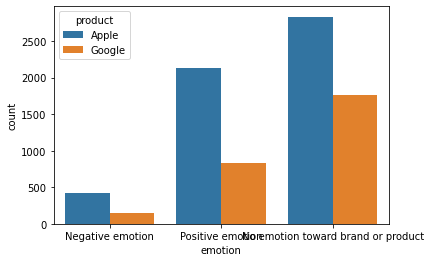

In [11]:
import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(df_1['emotion'], hue=df_1['product']);

The models require the target variable to be of integer type, so let's assign 0 to `Negative emotion`, 1 to `No emotion toward brand or product` and 2 to `Positive emotion`.

In [12]:
def number_map(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'No emotion toward brand or product':
        return 1
    else:
        return 0

In [13]:
df_1['emotion'] = df_1['emotion'].apply(number_map)

In [14]:
df_1['emotion'].value_counts()

1    4599
2    2962
0     569
Name: emotion, dtype: int64

## TRAIN TEST SPLIT

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1.drop('emotion',axis=1), df_1['emotion'], random_state=42)

## Addressing Class Imbalance using imblearn

In [16]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [17]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# print('Old shape of y:' + str(Counter(y)))
# print('New shape of y:' + str(Counter(y_ros)))

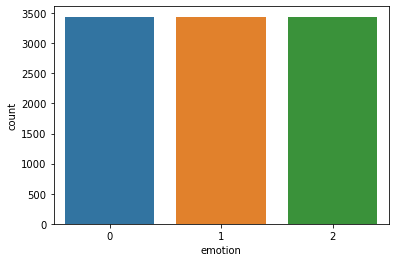

In [18]:
sns.countplot(y_train_ros);

In [19]:
X_train_ros['product'].value_counts()

Apple     7178
Google    3145
Name: product, dtype: int64

## Modeling

In [20]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=500, stop_words=stopwords_list, tokenizer=lemmatize_and_tokenize, strip_accents='ascii')

# Fit the vectorizer on X_train["text"] and transform it
X_train_ros_vectorized = tfidf.fit_transform(X_train_ros["tweet_text"])
# Visually inspect the vectorized data
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros_vectorized, columns=tfidf.get_feature_names())

In [21]:
# transforming the test data
X_test_vectorized = tfidf.transform(X_test['tweet_text'])
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

In [22]:
def evaluation_metric(model, X, y_true):
    y_pred = model.predict(X)
    conf_mtx = confusion_matrix(y_true, y_pred)
    accuracy = (conf_mtx[0,0]+conf_mtx[1,1]+conf_mtx[2,2]+conf_mtx[0,1]+conf_mtx[1,0]) / sum(sum(conf_mtx))
    return accuracy

In [23]:
# def cross_val_func(model, X, y):
#     cv_list = []
#     for i in range(5):
#         X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=42)
#         model.fit(X_train,y_train)
#         y_pred = model.predict(X_val) 
#         cv_list.append(evaluation_metric(y_val, y_pred))
#     return np.mean(cv_list)

In [24]:
# from sklearn.metrics.scorer import make_scorer
# custom_scorer = make_scorer(evaluation_metric, greater_is_better=True)

## Decision Tree

In [25]:
# function to evaluate the model
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [26]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier()
tree.fit(X_train_df, y_train_ros)
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 2, 5, 10],
#     'min_samples_split': [1, 5, 10, 20]
# }

# gs_tree = GridSearchCV(tree, param_grid, cv=3, scoring=evaluation_metric)
# gs_tree.fit(X_train_df, y_train_ros)
# gs_tree.best_params_

DecisionTreeClassifier()

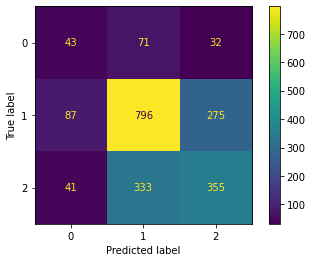

In [27]:
plot_confusion_matrix(tree,X_test_df,y_test);
# plot_confusion_matrix(gs_tree,X_test_df,y_test);

In [28]:
evaluation_metric(tree, X_test_df, y_test)
# evaluation_metric(gs_tree, X_test_df, y_test)

0.6650270536153468

## Logistic Regression

In [29]:
# logistic regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_df, y_train_ros)

LogisticRegression()

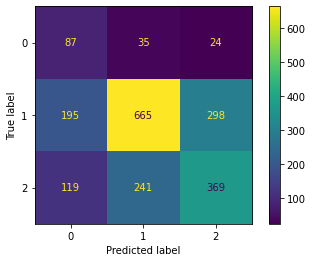

In [30]:
plot_confusion_matrix(log_reg,X_test_df,y_test);

In [31]:
evaluation_metric(log_reg, X_test_df, y_test)

0.6645351696999509

## Multinomial NB

In [32]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive.fit(X_train_df,y_train_ros)

MultinomialNB()

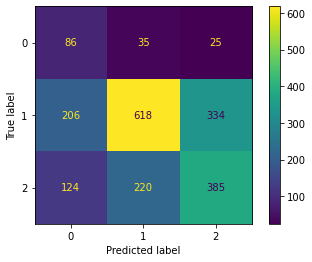

In [33]:
plot_confusion_matrix(naive,X_test_df,y_test);

In [34]:
evaluation_metric(naive, X_test_df, y_test)

0.6542056074766355

# TUNED DT,LOGREG AND NAIVE

## DT

In [45]:
tree = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': ["None",1, 2, 5],
    'min_samples_split': [2]
}

gs_tree = GridSearchCV(tree, param_grid, cv=3, scoring=evaluation_metric)
gs_tree.fit(X_train_df, y_train_ros)
gs_tree.best_params_

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}

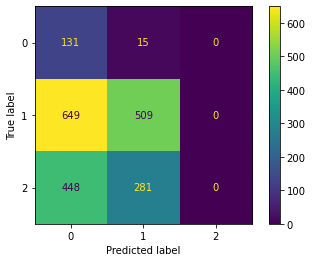

In [46]:
plot_confusion_matrix(gs_tree,X_test_df,y_test);

In [47]:
evaluation_metric(gs_tree, X_test_df, y_test)

0.6414166256763404

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Instantiate XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(X_train_df,y_train_ros)
# cross_val_func(xgboost, X_train_df, y_train_ros)

In [ ]:
plot_confusion_matrix(xgboost,X_test_df,y_test);

In [ ]:
xgboost_preds = xgboost.predict(X_test_df)
evaluation_metric(y_test, xgboost_preds)

# Conclusion

# Future Research

# Citations